In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as ss

def standardise(vec): return (vec - vec.mean()) / vec.std()
pd.set_option("display.max_rows", 500)

In [7]:
# KULLBACK-LEIBLER DIVERGENCE -- CHECKED
def KLD_dis(x, y, logbase=2):
    """Discrete kullback-Leibler divergence D(P(x)||Q(x)) for X, Y values stored in
    two arrays:
    - NOTE: there should be no events in x array that do not occur in y array
    - x: array with samples
    - y: array with samples
    - logbase: the base for the shannon entropy units
    """
    assert len(x) == len(y), "Arrays x and y have mismatching dimensions."

    # determining P(x)
    unique_x, count_x = np.unique(x, return_counts = True, axis=0)
    p_x = count_x / len(x)
    p_x = p_x[p_x > 0]

    # calculating the occurence of x in events in array y - Q(x)
    count_y = np.zeros((len(unique_x)))
    for i, x_val in enumerate(unique_x): # not the most efficient way, maybe there is a smarter way to 
        count_y[i] = np.count_nonzero(y == x_val)

    q_x = count_y/ len(y)
    q_x = q_x[q_x > 0]

    assert len(q_x) == len(p_x), "P(x) and Q(x) have mismatching dimensions."

    kl = np.sum(p_x * (np.log(p_x/q_x) / np.log(logbase)))
    return kl



def chisquared_distance(A, B):
 
    # compute the chi-squared distance using above formula
    chi = 0.5 * np.nansum([((a - b) ** 2) / (a + b)
                      for (a, b) in zip(A, B)], dtype="d")
 
    return chi

def distribution_metrics(dist,dist2, bins):
    log_dist = np.log10(dist)
    log_dist2= np.log10(dist2)

    hist1 = np.histogram(log_dist, bins=bins, range = (0,5), density=False)
    hist2 = np.histogram(log_dist2, bins=bins, range = (0,5), density=False)

    occurences1, bins1 = hist1
    occurences2, bins2 = hist2
    probability1 = occurences1/np.sum(occurences1)
    probability2 = occurences2/np.sum(occurences2)
    
    # entropy is the exact same function as the one used for KL divergence, 
    # if the input is just one probability array, then it calculates entropy
    # if the input are two probability arrays, then it calculates the KL divergence
    # SEE :https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

    Entropy1 = ss.entropy(probability1, base=2)
    Entropy2 = ss.entropy(probability2, base=2)
    CHI = chisquared_distance(probability1, probability2)
    KL = ss.entropy(probability1, probability2, base=2)
    return CHI, KL, Entropy1, Entropy2 


In [3]:
df1 = pd.read_parquet("../../data/big/A6_07-08.parquet")
df2 = pd.read_parquet("../../data/big/A6_04-05.parquet")
df1["date"] = pd.to_datetime(df1["timestamp"], unit="s")
df2["date"] = pd.to_datetime(df2["timestamp"], unit="s")

In [4]:
domain = "de.wikipedia"

df1_temp = df1[df1.domain == domain]
df2_temp = df2[df2.domain == domain]

df = pd.concat([df1_temp, df2_temp])

In [5]:
day1 = df[(df.date.dt.day == 6) & (df.date.dt.hour == 12)]
day2 = df[(df.date.dt.day == 4) & (df.date.dt.hour == 12)]
dds1 = [pd.to_datetime(i) for i in df1_temp.date.unique()]
dds2 = [pd.to_datetime(i) for i in df2_temp.date.unique()]

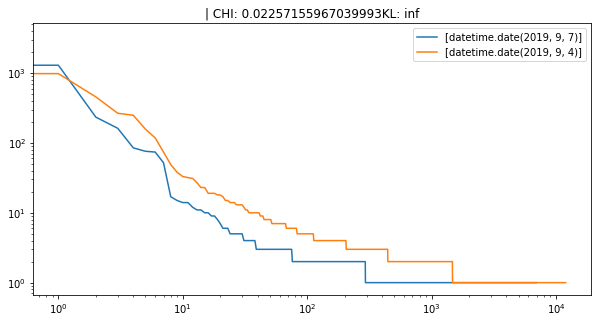

In [8]:
range = 1
for (d1, d2) in zip(dds1[0:range], dds2[0:range]):
    day1 = df[df["date"]==d1]
    day2 = df[df["date"]==d2]

    day1_sorted = sorted(day1["CumCount"])[::-1]
    day2_sorted = sorted(day2["CumCount"])[::-1]

    CHI, KL, bins1, bins2, occurence1, occurence2 = distribution_metrics(day1_sorted, day2_sorted, 20)

    plt.figure(figsize=(10,5))
    plt.title("| CHI: " + str(CHI) + "KL: " + str(KL))
    plt.loglog(sorted(day1["CumCount"])[::-1], label = day1.date.dt.date.unique())
    plt.loglog(sorted(day2["CumCount"])[::-1], label = day2.date.dt.date.unique())
    plt.legend()

    plt.show()


In [18]:
bins1

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

In [14]:
occurence1

array([6638,  255,   15,    7,    9,    0,    1,    3,    1,    1,    0,
          0,    1,    0,    1,    0,    0,    0,    0,    0])

In [13]:
day1["CumCount"]

165       1
166       1
167       1
168       1
169       1
         ..
545453    1
546624    2
547753    1
547760    1
547761    1
Name: CumCount, Length: 6932, dtype: int64

In [37]:
day2["CumCount"].shape

(11968,)

In [42]:
bins1

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

In [43]:
bins2

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])